In [27]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pandas_ta as ta
import vectorbt as vbt
import mt4_hst
%matplotlib inline

In [28]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015 # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,10000.0
size,100
size_type,amount
fees,0.0015
fixed_fees,0.0
slippage,0.0015
reject_prob,0.0
min_size,0.0


In [119]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame):
    # create neccesary indicators
    df.ta.percent_return(length=1, append=True)
    df.ta.sma(50, append=True)
    df.ta.ema(10, append=True)
    df.ta.ema(20, append=True)
    df.ta.donchian(lower_length=20, upper_length=20, append=True)
    df.ta.donchian(lower_length=10, upper_length=10, append=True)
    df.ta.donchian(lower_length=50, upper_length=50, append=True)
    df.ta.sma(close=df['volume'], length=20, prefix="VOLUME", append=True)
    
    # condition
    trend_cond = (
        (df['close'] > df['SMA_50'])
        & (df['EMA_10'] > df['EMA_20'])
        & (df['DCL_20_20'] > df['DCL_50_50'])
        # & (df['close'] > df['EMA_20'])
    ).astype(int)
    
    return trend_cond
    # return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

def trends_confirm_entries(df: pd.DataFrame):
    # candle pattern
    cdl_pattern = df.ta.cdl_pattern(
        name=["closingmarubozu", "marubozu", "engulfing", "longline"], 
        scalar=1).sum(axis=1).astype(bool).astype(int)
    volume_breakout = (df['volume'] >= 1.25 * ta.sma(df['volume'], 20)).astype(int)
    df['breakout'] = (
        cdl_pattern 
        * volume_breakout 
        # * (df['PCTRET_1'] > 0.04) 
        * (df['close'] > df['DCU_10_10'].shift())
    )
    
    # modify trends
    def modify_trend(df):
        return (
            df['trends'] * df['breakout']
        ).replace(0, np.nan).ffill().fillna(0).astype(int)

    groups = (df.trends != df.trends.shift()).cumsum()
    # df['groups'] = groups
    df['trends'] = df.groupby(groups).apply(modify_trend).to_list()
    df['trends'] = df['trends'].astype(bool)
    return df
    

In [148]:
df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")
df = df[(df['time'] <= '2022-06-30')]
df.index = df['time']
df['trends'] = trends(df)
df = trends_confirm_entries(df)
df.ta.tsignals(df['trends'], asbool=True, append=True);
# df.tail()
# df.to_csv('temp/df_signals.csv', index=False)

In [149]:
# df[df.breakout == 1].shape

# Backtest

In [150]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=df.TS_Entries,
    exits=df.TS_Exits,
)

In [151]:
fig = df.close.vbt.plot(trace_kwargs=dict(name='Close'))
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter…

In [141]:
assetpf_signals.stats()

Start                                2006-12-13 00:00:00
End                                  2020-06-30 00:00:00
Period                                3370 days 00:00:00
Start Value                                      10000.0
End Value                                   11575.047147
Total Return [%]                               15.750471
Benchmark Return [%]                           97.980728
Max Gross Exposure [%]                         30.614312
Total Fees Paid                               113.023502
Max Drawdown [%]                                5.729355
Max Drawdown Duration                  637 days 00:00:00
Total Trades                                          26
Total Closed Trades                                   26
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   57.692308
Best Trade [%]                                 54.145882
Worst Trade [%]                


    Annual return     :  1.10%
    Cumulative return :  15.75%
    Sharpe ratio      :  0.47
    Maximum Drawdown  : -5.73%
    Annual Volatility :  2.36%
    Value-At-Risk     :  nan%
    


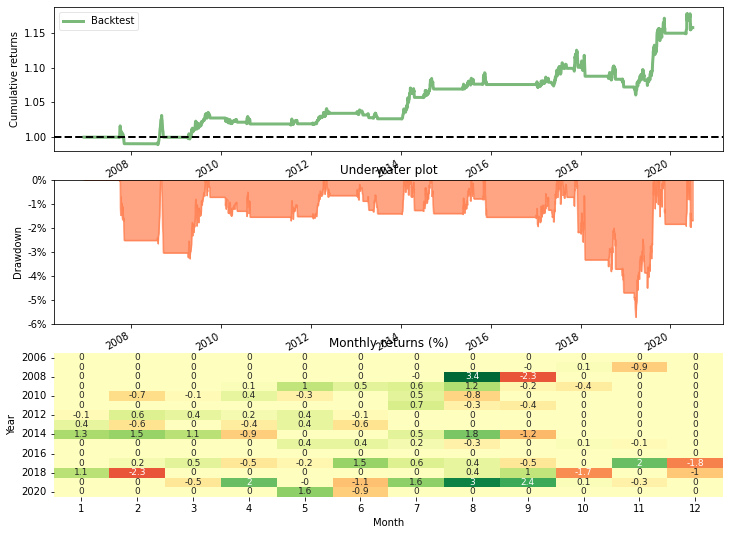

In [142]:
from stock_env.utils import create_performance
values = assetpf_signals.value()
values.index = df['time']
returns = values.pct_change()
create_performance(returns)

In [147]:
values.vbt.drawdowns.plot(top_n=3)

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'showlegend': False,
              't…